In [15]:
import numpy as np                 #loading in numpy
from matplotlib import pyplot as plt      #load matplotlib
import math                        # load math in 
#this makes matplotlib plots appear in the notebook (instead of a separate window)
%matplotlib inline

# Couette Flow of Incompressible Flow: Crank-Nicolson Method 
In previous examples, we have looked at inviscid compressible flow using explicit mehtods. Now we are going to explore a prbloem with an non-compressible viscous fluid. Additionally, we will be solving this problem with an implicit mehtod. More specifically, we will be implimenting the Crank-Nicolson implicit mehtod. 
The system we will be modeling is Couette flow which can be thought of as a fluid inbetween two parallel plates separated by some distance D. The upper plate is moving at some velocity and the lover plate is stationary. The flow field between the plates is driven purely by the shear stresses along the wall of the plates. This results in a velocity profile across the flow $u = u(y)$.

## The Analytical Approach

the governing equation for this flow is the x-momentum equation 

$$ \rho \frac{Du}{Dt} = -\frac{\partial p}{\partial x} + \frac{\partial \tau_{xx}}{\partial x} + \frac{\partial \tau_{yx}}{\partial y} + \frac{\partial \tau_{zx}}{\partial z}+\rho f_x$$

This equation is simplified even further if we use a model that is infinitely long in the x-direction. This makes our equation independent of x therefor $\partial / \partial x = 0$. The continuity equation for steady flow can be written as:


$$\frac{\partial(\rho u)}{\partial x}+ \frac{\partial (\rho v)}{\partial y} = 0$$

and since $\partial / \partial x = 0$ we can write

$$\frac{\partial (\rho v)}{\partial y} = \rho \frac{\partial v}{\partial y} + v \frac{\partial \rho}{\partial y} = 0$$

If we evaluate this at the lower wall where $v = 0$ and $y = 0$ we get

$$\Big(\rho \frac{\partial v}{\partial y}\Big)_{y=0} = 0$$

or

$$\Big( \frac{\partial v}{\partial y}\Big)_{y=0} = 0$$


If we expand $v$ in a tTaylor series about the point $y=0$ we get the following equations

$$v(y) = v(0) + \Big(\frac{\partial v}{\partial y}\Big)_{y=0} y+ \Big(\frac{\partial ^2c}{\partial y^2}\Big)_{y=0}\frac{y^2}{2}+ ...$$

If we do the same thing for the upper wall, we get

$$v(D) = v(0) + \Big(\frac{\partial v}{\partial y}\Big)_{y=0} D+ \Big(\frac{\partial ^2c}{\partial y^2}\Big)_{y=0}\frac{D^2}{2}+ ...$$

Because $v(D)=0$, $v(0)=0$ and $[\partial v/\partial y] _ {y=0} = 0$ it makes sense to say that for all of the points, the value of $v$ is equal to zero. This is an important characteristic of Couette flow. There is non y velocity comonenet in the flow. Becuase there is no movement in the y direction and there are no body forces, we can also assume that there is no change in pressure in the y direction.

$$\frac{\partial p }{\partial y}=0$$

There are no pressure gradients in the x or y direction. With the information we have now, we can go back to out momentum equation and reduce it to the following equation

$$\rho u \frac{\partial u}{\partial x} + \rho v \frac{\partial u}{\partial y} = - \frac{\partial p }{\partial x} + \frac{\partial \tau_{xx} }{\partial x}+\frac{\partial \tau_{yx} }{\partial y}$$

The equations for the stress terms are

$$\tau_{xx} = \lambda \Big(\frac{\partial u}{\partial x}+\frac{\partial v}{\partial y}\Big) + 2\mu \frac{\partial u}{\partial x}=0$$

$$\tau_{yx} = \mu \Big(\frac{\partial v}{\partial x}+\frac{\partial u}{\partial y}\Big) = \mu \frac{\partial u}{\partial y}$$


Substituting the last two equations with our new momentum equation, we get

$$0=\frac{\partial}{\partial y}\Big(\mu \frac{\partial u}{\partial y}\Big)$$

If we assume an incompressible, constant-temperature flow for which $\mu$ is constant, the equation simplifies to 

$$\frac{\partial ^2 u}{\partial y^2} = 0$$

This is a thing of beauty. We have taken a physical problem (with many assumptions and simplifications) and reduced it to a second order partial differential equation. Even more impressive is that this has an analytical solution

$$u = c_1 y + c_2$$

We get this solution from integrating twice. Solving for the constant with the known boundary conditions, we get

$$\frac{u}{u_e} = \frac{y}{D}$$

This solution tells us that for Couette flow, the u velocity gradient will be linear. We can now use this analytical solution to check our CFD code. This is very important, because it is how we build confidence in numerical solutions and anchor them to what we know is correct. From there we can attempt to extrapolate and interpolate within a reasonable range and get answers to problems we cannot solve analytically. 



## The Numerical Approach 


We will begin the numerical solution with a flow filed that is not linear like the exact analytical solution. Instead, we will have a discontinuous profile where the flow is 0 for the entire flow except at $y = D$, the flow will be set to some velocity $u_e$. The figure below shows what this profile looks like graphically.

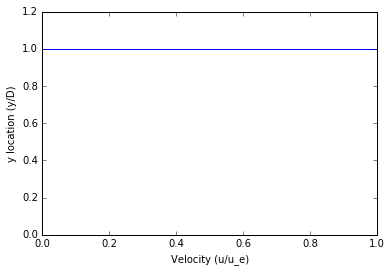

In [16]:
x = np.linspace(0,1,100)
y = np.ones(100)
plt.plot(x,y)
plt.xlim([0,1])
plt.ylim([0,1.2])
plt.xlabel('Velocity (u/u_e)')
plt.ylabel('y location (y/D)')

When starting from this profile and progressing to the steady state solution, the governing equation for momentum can be written as

$$\rho \frac{\partial u}{\partial t} = \mu \frac{\partial ^2 u}{\partial y^2}$$

To make out calculations easier, we will convert to a nondimensional form

$$u' = \frac{u}{u_e}$$

$$y' = \frac{y}{D}$$

$$t' = \frac{t}{D/u_e}$$

Plugging these values into the governing equation

$$\rho \frac{\partial(u/u_e)}{\partial [t/(D/u_e)]} \Big(\frac{u_e^2}{D}\Big) = \mu \frac{\partial^2 (u/u_e)}{\partial (y/D)} \Big(\frac{u_e}{D^2}\Big)$$

or 

$$\frac{\partial u'}{\partial t'} = \frac{\mu}{\rho u_e D}\frac{\partial ^2 u'}{\partial y'^2}$$

We can simplify this further by tating that 

$$\frac{\mu}{\rho u_e D} = \frac{1}{Re_D}$$

This is the Reynolds number based on the height D between the two plates. 

Using this equation we are left with

$$\frac{\partial u'}{\partial t'} = \frac{1}{Re_D}\frac{\partial ^2 u'}{\partial y'^2}$$

Now that we have our equation, we can apply a numerical scheme to solve it. For this example, we will be using the Crank-Nicolson technique

$$\frac{u_j^{n+1}-u_j^{n}}{\Delta t} = \frac{1}{Re_D}\frac{\frac{1}{2} (u_{j+1}^{n+1}+u_{j+1}^n) +\frac{1}{2} (-2u_j^{n+1} - 2u_j^n)+ \frac{1}{2} (u_{j-1}^{n+1} + u_{j-1}^n )}{(\Delta y)^2}$$

Then solve for $u_j^{n+1}$

$$u_j^{n+1} =u_j^n + \frac{\Delta t}{2(\Delta y)^2 Re_D}(u_{j+1}^{n+1}+u_{j+1}^n -2u_j^{n+1} - 2u_j^n+u_{j-1}^{n+1} + u_{j-1}^n ) $$

We still have sone values with the super script $n+1$ on the right side, so lets move those over and combine like terms. 

$$\Big[-\frac{\Delta t}{2(\Delta y)^2 Re_D}\Big]u_{j-1}^{n+1} + \Big[1+\frac{\Delta t}{(\Delta y)^2 Re_D}\Big]u_j^{n+1}+\Big[-\frac{\Delta t}{2(\Delta y)^2 Re_D}\Big]u_{j+1}^{n+1} = \Big[1-\frac{\Delta t}{(\Delta y)^2 Re_D}\Big]u_j^n +\frac{\Delta t}{2(\Delta y)^2 Re_D}(u_{j+1}^n +u_{j-1}^n ) $$

Reducing this equation to the form of 

$$Au_{j-1}^{n+1}+Bu_j^{n+1}+Au_{j+1}^{n+1} = K_j$$

Where:

$$A = -\frac{\Delta t}{2(\Delta y)^2 Re_D}$$

$$B =1+\frac{\Delta t}{(\Delta y)^2 Re_D} $$

$$K_j = \Big[1-\frac{\Delta t}{(\Delta y)^2 Re_D}\Big]u_j^n +\frac{\Delta t}{2(\Delta y)^2 Re_D}(u_{j+1}^n +u_{j-1}^n ) $$


Because this problem is 1 dimensional at this point, our grid will resemble equally spaced points on a vertical line as shown below.


(-0.00080000000000000004, 0.00080000000000000004, 0.0, 1.0)

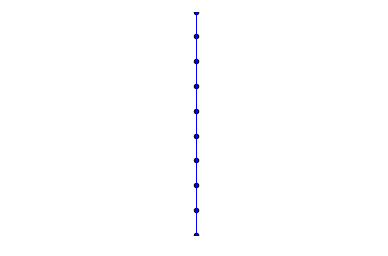

In [17]:
y = np.linspace(0,1,100)
x = np.zeros(100)
yPts = np.linspace(0,1,10)
xPts = np.zeros(10)
plt.plot(x,y)
plt.scatter(xPts,yPts)
plt.ylim([0,1])
plt.axis('off')

The vertical distance between points will be 

$$\Delta y = \frac{D}{N}$$

N being the number of points we choose to use for our simulation. The boundary conditions are as follows:

$$u_1 = 0$$

$$u_{N+1} = 1$$

The following equation that we derived applied to every grid point in the flow field which means we have $N-1$ equations with $N-1$ unknowns. 
$$Au_{j-1}^{n+1}+Bu_j^{n+1}+Au_{j+1}^{n+1} = K_j$$

\begin{equation*}
    \begin{bmatrix}
        B & A & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
        A & B & A & 0 & 0 & 0 & 0 & 0 & 0\\
        0 & A & B & A & 0 & 0 & 0 & 0 & 0\\
        0 & 0 & A & B & A & 0 & 0 & 0 & 0\\
          &   &   & ...  &   &   &   &   &  \\
          &   &   &   &  ... &   &   &   &  \\
          &   &   &   &   & ...  &   &   &  \\
        0 & 0 & 0 & 0 & 0 & 0 & A & B & A\\
        0 & 0 & 0 & 0 & 0 & 0 & 0 & A & B\\
    \end{bmatrix}
    \begin{bmatrix}
        u^{n+1}_2\\
        u^{n+1}_3\\
        u^{n+1}_4\\
        u^{n+1}_5\\
        .\\
        .\\
        .\\
        u^{n+1}_{N-1}\\
        u^{n+1}_{N}\\
    \end{bmatrix}
    =
    \begin{bmatrix}
        K_2\\
        K_3\\
        K_4\\
        K_5\\
        .\\
        .\\
        .\\
        K_{N-1}\\
        K_{n}-Au_e\\
    \end{bmatrix}    
\end{equation*}

This tridagonal matrix represents our system and can be solved using Thomas' algorithm. So let's take a minute to examine the algorithm. 

This algorithm is based on gaussian elimination. To put the system in more generic terms we will use the following system of equations. 

$$d_1u_1+a_1u_2 = c_1$$

$$b_2u_1+d_2u_2+a_2u_3 = c_2$$

$$b_3u_2+d_3u_3+a_3u_4 = c_3$$

$$...$$

$$...$$

$$...$$

$$b_{M-1}u_{M-2}+ d_{M-1}u_{M-1}+a_{M-1}u_M = c_{M-1}$$

$$b_Mu_{M-1}+d_{M}u_M=c_M$$


There are three terms for each row, a b and d. You can think of this as above the diagonal(a), below the diagonal(b) and the diagonal(d). 
We first march down the matrix to eliminate one term. First, we multiply the first row by $b_2$. 

$$b_2d_1u_1 + b_2a_1u_2 = c_1 b_2$$

Then we multiply the second equation by $d_1$

$$d_1b_2u_1 + d_1d_2u_2 + d_1a_2u_3 = c_2d_1$$

Now we subtract the two equations we just calculated

$$(d_1d_2-b_2a_1)u_2 + d_1a_2u_3 = c_2d_1 - c_1b_2$$

Then we divide by $d_1$

$$\Big(d_2 - \frac{b_2a_1}{d_1}\Big)u_2 + a_2u_3 = c_2 - \frac{c_1b_2}{d_1}$$

The goal of this process was to eliminate the lower diagonal term $u_1$ in this example. We have now reduced this row to only two terms. We can write our new coefficients as such

$$d'_2 = d_2 - \frac{b_2a_1}{d_1}$$

$$c'_2 = c_2 - \frac{c_1b_2}{d_1}$$

This equation simplifies down to 

$$d'_2u_2 + a_2u_3 = c'_2$$


We will continue the next step by following the procedure above. Begin again by multiplying $b_3$.

$$b_3d'_2u_2 + b_3a_2u_3 = b_3c'_2$$

Then mulitply by $d'_2$

$$d'_2b_3u_2 + d'_2d_3u_3 + d'_2a_3u_4 = d'_2c_3$$

Now we subtract the two equations we just calculated

$$(d'_2d_3-b_3a_2)u_3+d'_2a_3u_4 = d'_2c_3 - b_3c'_2$$

Then we divide by $d'_2$

$$\Big(d_3 - \frac{b_3a_2}{d'_2}\Big)u_3 + a_3u_4 = c_3 - \frac{b_3c'_2}{d'_2}$$

If we continue further, we will see that the coefficients are in the same form al the way down the matrix. We can replace the main-diagonal coefficient with

$$d_2-\frac{b_2a_1}{d_1}$$

We can also replace the term on the right hand side of the equation with

$$c_2 - \frac{c_1b_2}{d_1}$$

Written in a general form, we get the following

$$d'_i = d_i - \frac{b_ia_{i-1}}{d'_{i-1}} : i = 2,3,...,M$$

$$c'_i = c_i - \frac{c'_{i-1} b_i}{d'_{i-1}} : i = 2,3,...,M$$

This reduces our matrix to a bidiagonal form. And further examination will show that the last term is reduced to only one unknown

$$u_M = \frac{c'_M}{d'_M}$$

We can solve this equation and work upwards to solve the rest of the matrix with this equation

$$u_i = \frac{c'_i - a_i u_{i+1}}{d'_i}$$

So now let us write a function that will solve the tri diagonal matrix.

In [204]:
def thomasAlg(b,d,a,c):
    """
    b,d,a, and c are arrays with length N
    The first value of b (b[0]) and the last
    value of a (a[N]) will be ignored
    """
    #Calculate  dPrime and cPrime
    length = len(a)
    dPrime = np.zeros(length)
    cPrime = np.zeros(length)
    
    # First row is already two terms
    dPrime[1] = d[1]
    cPrime[1] = c[1]
    # Gaussian elimination
    for i in range(2,length):
        dPrime[i]=d[i]-(b[i]*a[i-1])/dPrime[i-1]
        cPrime[i] = c[i]-(cPrime[i-1]*b[i])/dPrime[i-1]
    
    # Working upward 
    u = np.zeros(length)
    # Solve row N-1
    u[length-2] = cPrime[length-2]/dPrime[length-2]
    # Work up from the bottom
    for i in range(length-3,0,-1):
        u[i] = (cPrime[i]-a[i]*u[i+1])/dPrime[i]
    return u

## The Setup 
Now that we have our well posed problem and the numerics to solve the problem we can set up our problem. For our exaple, we will use 21 grid points meaning we have a delta in the y direction of 

$\Delta y = \frac{1}{20}$

Our initial conditions are arean array of values for u

In [19]:
u = np.zeros(21) # all nodes except upper wall arte zero
u[20] = 1 # wall BC set to reference velocity

Now we need to figure out what our timestep is. The main advantage of this implicit method is that it is unconditionally stable whih means that it is stable for all values of $\Delta t$. However, we do want an accurate solution so we will use the following equation.

$$\frac{\alpha \Delta t}{(\Delta x)^2}\leq\frac{1}{2}$$

For an explicit method, we can write 

$$\frac{1}{Re_D}\frac{\Delta t}{(\Delta x)^2}\leq \frac{1}{2}$$

$$\Delta t \leq \frac{1}{2}Re_D (\Delta y)^2$$

For our present implicit mehtod, we will calculate $\Delta t$ as such

$$\Delta t = E Re_D (\Delta y)^2$$

Where E is a parameter to tune our simulation. We can also use this term to simplify our calculations of A, B , and K.

$$E = \frac{\Delta t}{Re_D (\Delta y)^2}$$

$$A = -\frac{E}{2}$$

$$B = 1+E$$

$$K_j = (1+E)u_j^n + \frac{E}{2}(u_{j+1}^n + u_{j-1^n})$$

We now have all of the equations required for the simulation. We will be using the follownig parameter

$$E=1$$

$$Re_D = 5000$$

$$\Delta t  = E Re_D (\Delta y)^2 = 1(5000)(0.05)^2 = 12.5$$

In [191]:
def main(iters,nodes):
    u = np.zeros([nodes,iters])
    u[0,0] = 0 
    u[nodes-1,0] = 1
    deltay = 1/(nodes-1)
    E=1
    reD = 5000
    deltat = E*reD*deltay**2
    # our matrix will be N-2 by N-2 because we leave out the BC's
    A = np.ones(nodes)*(-E/2)
    B = np.ones(nodes)*(1+E)
    K = np.zeros(nodes)
    # Nodes 1 and 21 are known
    for i in range(0,iters-1):
        for j in range(1,nodes-1): 
            K[j] = (1-E)*u[j,i] + (E/2)*(u[j+1,i]+u[j-1,i]) 
        K[-2] = K[-2]-A[-2]
        u[:,i+1] =thomasAlg(A,B,A,K)
        u[-1,i+1]=1
    return u

In [205]:
u =main(200,21)

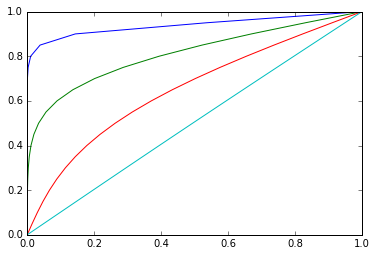

In [207]:
y = np.linspace(0,1,len(u[:,0]))
plt.plot(u[:,1],y)
plt.plot(u[:,11],y)
plt.plot(u[:,40],y)
plt.plot(u[:,190],y)

9.0
